In [1]:
import os
import sys
import time
import pickle
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt

from ast import literal_eval
from scipy.integrate import odeint

from sklearn.model_selection import train_test_split

from sysidentpy.utils.display_results import results
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial

# To ignore UserWarnings
import warnings
warnings.filterwarnings('ignore')

# Import local function
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), 'src'))

from metrics import get_metrics_df
from narmax.utils import narmax_state_space, display_nx_model
from networks.utils import barabasi_sol, barabasi_diff

In [2]:
# Custom function for identification
custom_library = ps.CustomLibrary(library_functions=[lambda x, y : x / y], 
                                  function_names=[lambda x, y : x + '/' + y])

In [3]:
# Get Averaged Model
file = '100_Barabási–Albert_None_(10000,2).dat'
folder_path = os.path.join(os.path.abspath(''), '..', 'Data', 'Generated', 'Barabasi')
file_path = os.path.join(folder_path, file)

with open(file_path, "rb") as input_file:
    data = pickle.load(input_file)

# Get Model characteristics from filename
net_args = file.split('_')
gen_args = literal_eval(net_args[-1].replace('.dat', ''))

# Load Simulated Data
m = gen_args[1]
n = gen_args[0]
t = np.arange(1, n - m + 1)

avg_degrees_hist = data['avg_degree']
k = avg_degrees_hist[:,0]

# Split Data into Train-Test
k_train, k_test, t_train, t_test = train_test_split(k, t, test_size=0.6, shuffle=False)

In [4]:
# Define analytical solutions for the model
k_ant = barabasi_sol(m, 1, t)
k_dif = odeint(barabasi_diff, 2, t).flatten() # Degree evolution from differential equations
sol_terms = [['k/t']]

In [5]:
# Define SINDy Model
sindy_model = ps.SINDy(
    differentiation_method=ps.FiniteDifference(),
    feature_library=custom_library+ps.PolynomialLibrary(degree=5),
    optimizer=ps.STLSQ(threshold=1e-2),
    feature_names=['k', 't']
)

# Fit model and get time taken
tic = time.time()
sindy_model.fit(k_train, u=t_train, quiet=True)
toc = time.time()
sindy_time = toc - tic

# Print resulting model
sindy_model.print()

# Simulate SINDy on the test data
sindy_sim = sindy_model.simulate(k_test[0], u=t_test, t=t_test)
sindy_sim = np.vstack((k_test[0], sindy_sim))

k' = 0.470 k/t


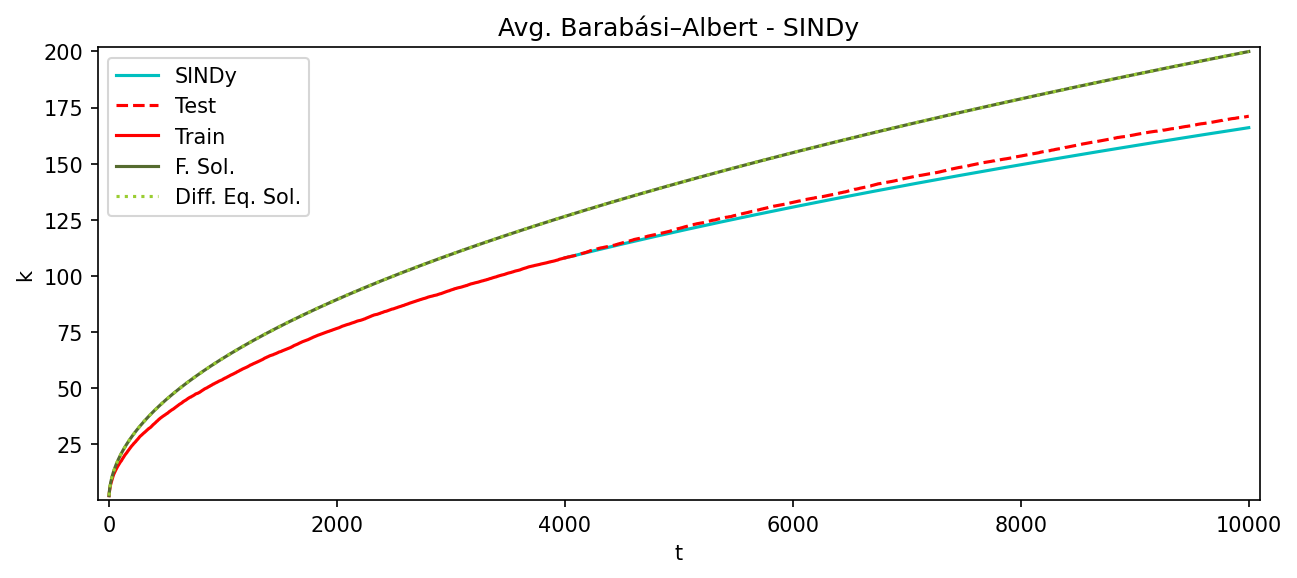

In [6]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('Avg. Barabási–Albert - SINDy')
plt.plot(t_test, sindy_sim, "c", label="SINDy")
plt.plot(t_test, k_test, "r--", label="Test")
plt.plot(t_train, k_train, "r", label="Train")
plt.plot(t, k_ant, color='darkolivegreen', label="F. Sol.")
plt.plot(t, k_dif, color='yellowgreen', linestyle='dotted', label="Diff. Eq. Sol.")
plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.ylabel("k")
plt.legend()
print(end='')

In [7]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
nx_model = FROLS(
    order_selection=True,
    info_criteria='bic',
    ylag=1, xlag=1,
    estimator='least_squares',
    basis_function=Polynomial(degree=2)
)

# Conformal Mapping of Time, to adjust into Polynomial Basis
x_train = 1/t_train
x_test = 1/t_test

# Train model for the state X and get time
tic = time.time()
nx_model.fit(X=x_train.reshape(-1, 1), y=k_train.reshape(-1, 1))
toc = time.time()
narmax_time = toc - tic
# Get model parameters for the state X and print
coeffs_y = np.pad(nx_model.theta.flatten(), (0, nx_model.basis_function.__sizeof__() - len(nx_model.theta)))
params = results(nx_model.final_model, nx_model.theta, nx_model.err, nx_model.n_terms, dtype='sci')
display_nx_model(params, nx_model.theta, 'k', ['1/t'], 1)
# Simulate model for the state X
sim_y = nx_model.predict(X=x_test.reshape(-1, 1), y=k_test[0].reshape(-1, 1))

# Stack results for models and predictions
narmax_model = {}
narmax_model['features'] =  ['k', 't']
narmax_model['coeffs'] = np.array([coeffs_y])
narmax_model['regs'] = [[list(eq) for eq in nx_model.final_model]]
narmax_sim = sim_y

k[k+1] = 1.000E+00 k[k] + 5.106E-01 1/t[k]k[k] - 3.087E-01 1/t[k]


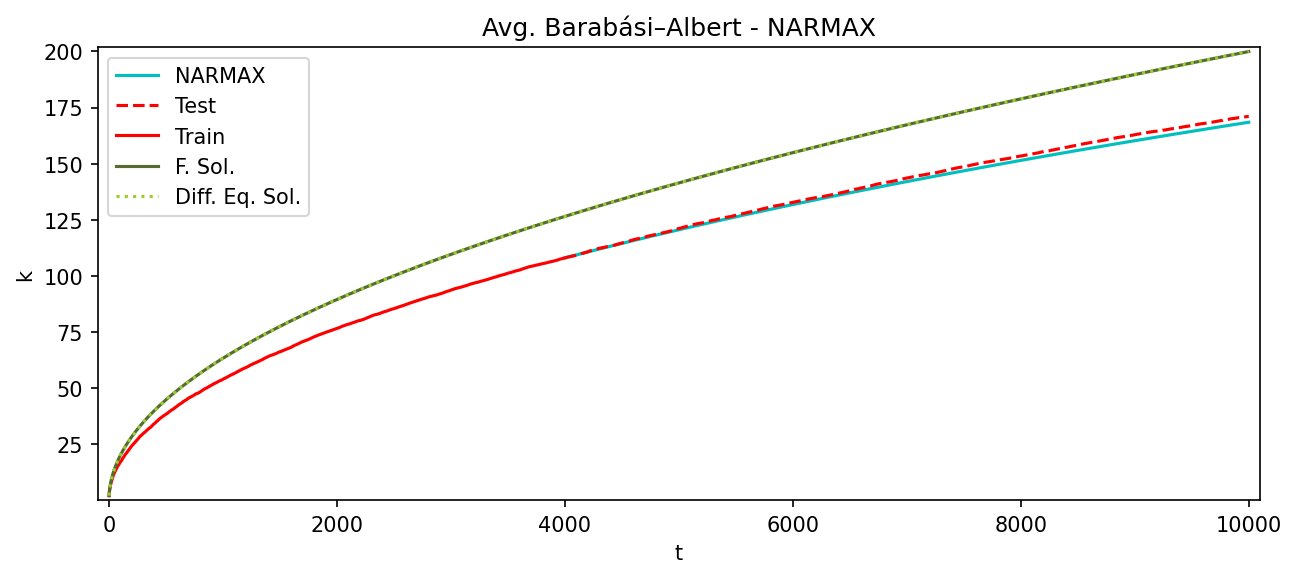

In [8]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('Avg. Barabási–Albert - NARMAX')
plt.plot(t_test, narmax_sim, "c", label="NARMAX")
plt.plot(t_test, k_test, "r--", label="Test")
plt.plot(t_train, k_train, "r", label="Train")
plt.plot(t, k_ant, color='darkolivegreen', label="F. Sol.")
plt.plot(t, k_dif, color='yellowgreen', linestyle='dotted', label="Diff. Eq. Sol.")
plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.ylabel("k")
plt.legend()
print(end='')

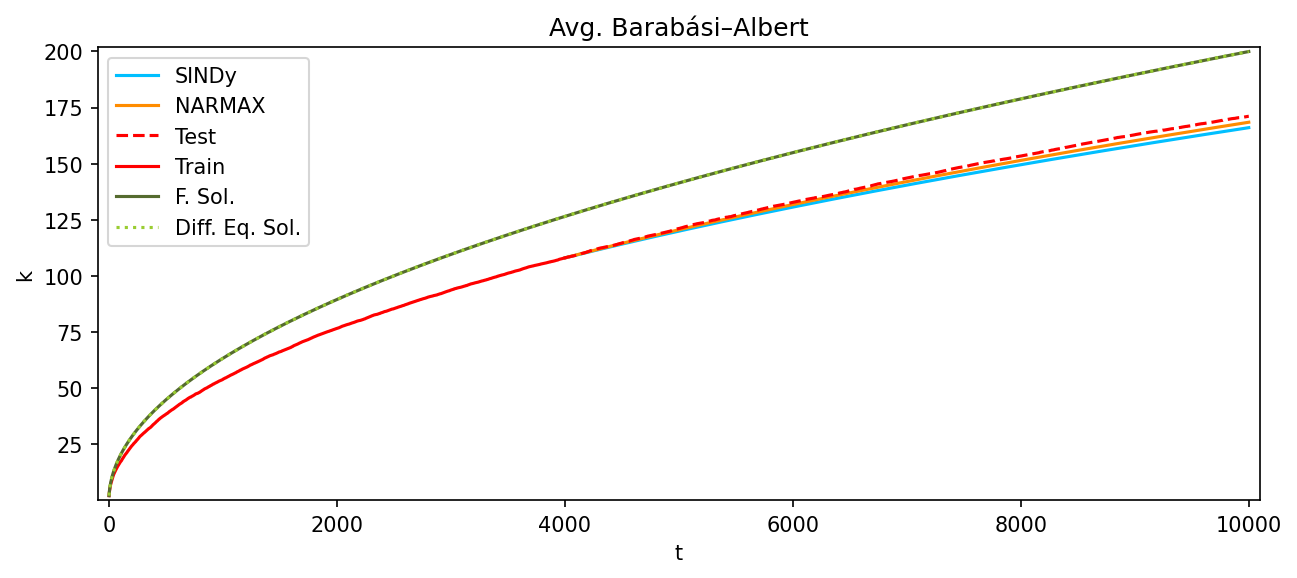

In [9]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('Avg. Barabási–Albert')
plt.plot(t_test, sindy_sim, 'deepskyblue', label='SINDy')
plt.plot(t_test, narmax_sim, 'darkorange', label='NARMAX')
plt.plot(t_test, k_test, 'r--', label='Test')
plt.plot(t_train, k_train, 'r', label='Train')
plt.plot(t, k_ant, color='darkolivegreen', label='F. Sol.')
plt.plot(t, k_dif, color='yellowgreen', linestyle='dotted', label='Diff. Eq. Sol.')
plt.margins(0.01, tight=True)
plt.xlabel('t')
plt.ylabel('k')
plt.legend()
print(end='')

In [10]:
# Metrics DataFrame
get_metrics_df(k_test, sol_terms, sindy_model, narmax_model, sindy_sim, narmax_sim, sindy_time, narmax_time)

,CII,COI,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,Time
SINDy,[True],True,[1],[0],1,2.937112,11.082844,113.844940,0.057972
NARMAX,[True],True,[3],[2],3,1.486561,2.981443,112.094064,0.016893


In [11]:
# Get Single Case Model
file = '1_Barabási–Albert_None_(10000,2).dat'
folder_path = os.path.join(os.path.abspath(''), '..', 'Data', 'Generated', 'Barabasi')
file_path = os.path.join(folder_path, file)

with open(file_path, "rb") as input_file:
    data = pickle.load(input_file)

# Get Model characteristics from filename
net_args = file.split('_')
gen_args = literal_eval(net_args[-1].replace('.dat', ''))

# Load Simulated Data
m = gen_args[1]
n = gen_args[0]
t = np.arange(1, n - m + 1)

avg_degrees_hist = data['avg_degree']
k = avg_degrees_hist[:,0]

# Split Data into Train-Test
k_train, k_test, t_train, t_test = train_test_split(k, t, test_size=0.6, shuffle=False)

In [12]:
# Define SINDy Model
sindy_model = ps.SINDy(
    differentiation_method=ps.FiniteDifference(),
    feature_library=custom_library + ps.PolynomialLibrary(degree=2),
    optimizer=ps.STLSQ(threshold=1e-2),
    feature_names=['k', 't']
)

# Fit model and get time taken
tic = time.time()
sindy_model.fit(k_train, u=t_train, quiet=True)
toc = time.time()
sindy_time = toc - tic

# Print resulting model
sindy_model.print()

# Simulate SINDy on the test data
sindy_sim = sindy_model.simulate(k_test[0], u=t_test, t=t_test)
sindy_sim = np.vstack((k_test[0], sindy_sim))

k' = 0.508 k/t


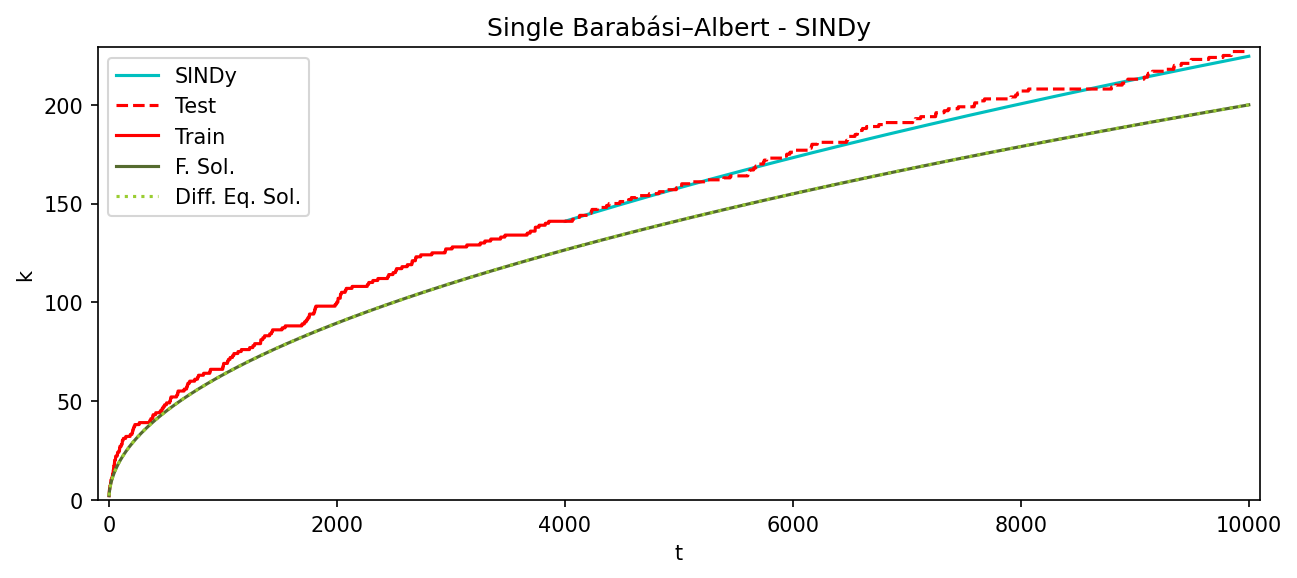

In [13]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('Single Barabási–Albert - SINDy')
plt.plot(t_test, sindy_sim, "c", label="SINDy")
plt.plot(t_test, k_test, "r--", label="Test")
plt.plot(t_train, k_train, "r", label="Train")
plt.plot(t, k_ant, color='darkolivegreen', label="F. Sol.")
plt.plot(t, k_dif, color='yellowgreen', linestyle='dotted', label="Diff. Eq. Sol.")
plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.ylabel("k")
plt.legend()
print(end='')

In [14]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
nx_model = FROLS(
    order_selection=True,
    info_criteria='bic',
    ylag=1, xlag=1,
    estimator='least_squares',
    basis_function=Polynomial(degree=2)
)

# Conformal Mapping of Time, to adjust into Polynomial Basis
x_train = 1/t_train
x_test = 1/t_test

# Train model for the state X and get time
tic = time.time()
nx_model.fit(X=x_train.reshape(-1, 1), y=k_train.reshape(-1, 1))
toc = time.time()
narmax_time = toc - tic
# Get model parameters for the state X and print
coeffs_y = np.pad(nx_model.theta.flatten(), (0, nx_model.basis_function.__sizeof__() - len(nx_model.theta)))
params = results(nx_model.final_model, nx_model.theta, nx_model.err, nx_model.n_terms, dtype='sci')
display_nx_model(params, nx_model.theta, 'k', ['1/t'], 1)
# Simulate model for the state X
sim_y = nx_model.predict(X=x_test.reshape(-1, 1), y=k_test[0].reshape(-1, 1))

# Stack results for models and predictions
narmax_model = {}
narmax_model['features'] =  ['k', 't']
narmax_model['coeffs'] = np.array([coeffs_y])
narmax_model['regs'] = [[list(eq) for eq in nx_model.final_model]]
narmax_sim = sim_y

k[k+1] = 1.000E+00 k[k] + 4.917E-01 1/t[k]k[k]


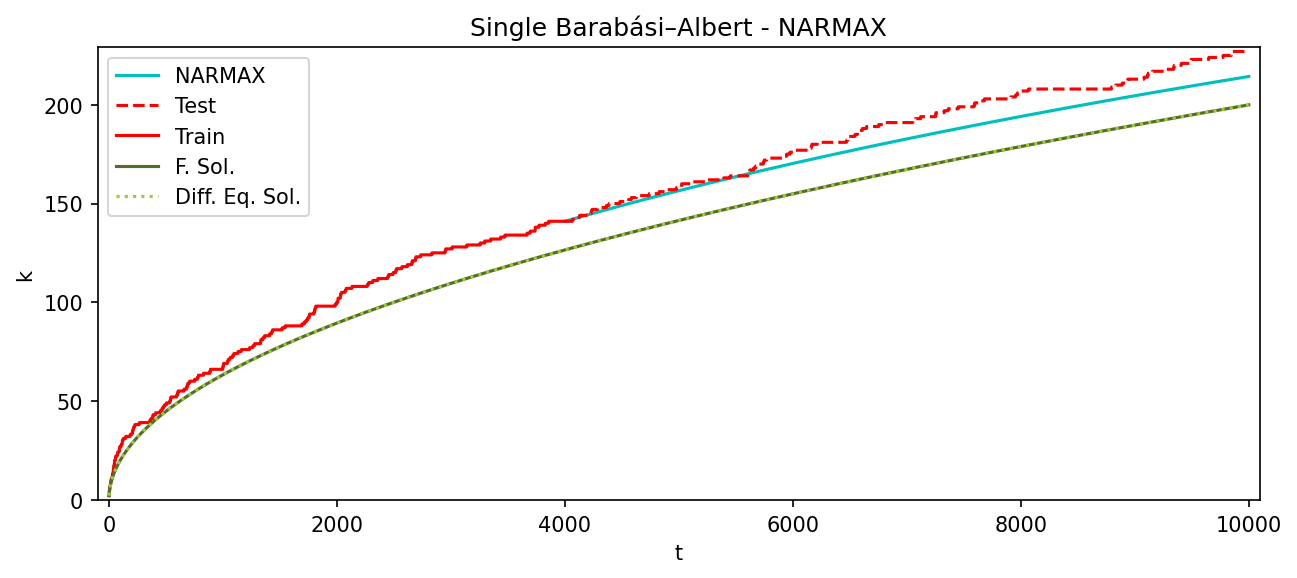

In [15]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('Single Barabási–Albert - NARMAX')
plt.plot(t_test, narmax_sim, "c", label="NARMAX")
plt.plot(t_test, k_test, "r--", label="Test")
plt.plot(t_train, k_train, "r", label="Train")
plt.plot(t, k_ant, color='darkolivegreen', label="F. Sol.")
plt.plot(t, k_dif, color='yellowgreen', linestyle='dotted', label="Diff. Eq. Sol.")
plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.ylabel("k")
plt.legend()
print(end='')

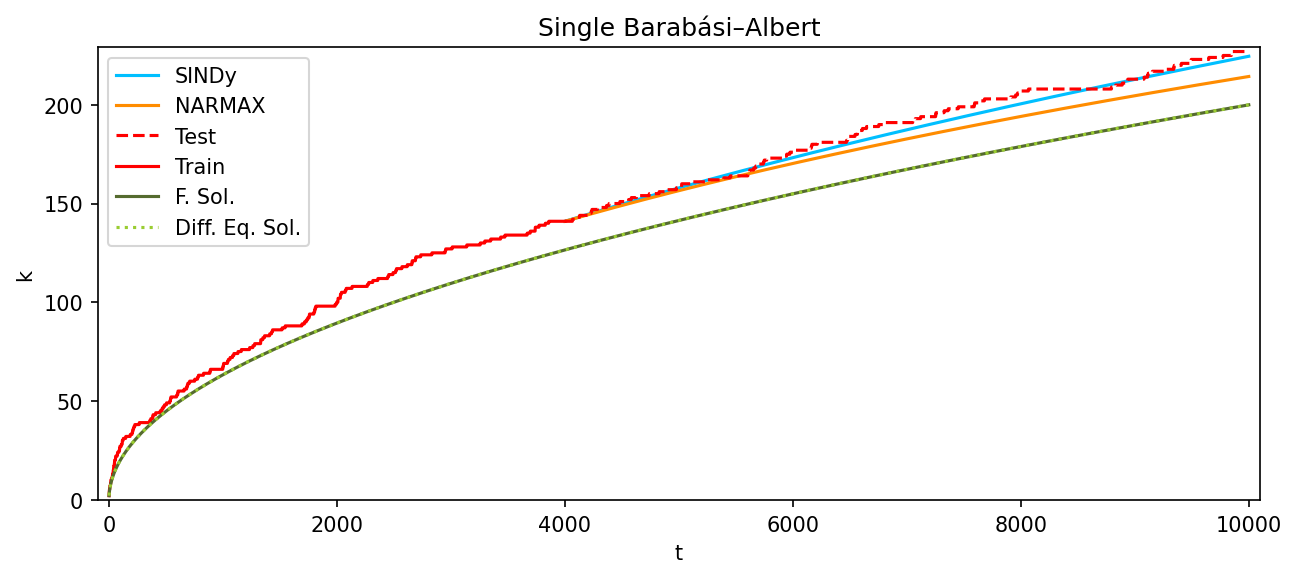

In [16]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('Single Barabási–Albert')
plt.plot(t_test, sindy_sim, 'deepskyblue', label='SINDy')
plt.plot(t_test, narmax_sim, 'darkorange', label='NARMAX')
plt.plot(t_test, k_test, 'r--', label='Test')
plt.plot(t_train, k_train, 'r', label='Train')
plt.plot(t, k_ant, color='darkolivegreen', label='F. Sol.')
plt.plot(t, k_dif, color='yellowgreen', linestyle='dotted', label='Diff. Eq. Sol.')
plt.margins(0.01, tight=True)
plt.xlabel('t')
plt.ylabel('k')
plt.legend()
print(end='')

In [17]:
# Metrics DataFrame
get_metrics_df(k_test, sol_terms, sindy_model, narmax_model, sindy_sim, narmax_sim, sindy_time, narmax_time)

,CII,COI,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,Time
SINDy,[True],True,[1],[0],1,2.266907,10.357563,111.165730,0.029444
NARMAX,[True],True,[2],[1],2,7.050066,67.501417,116.219979,0.029781


In [18]:
# Define SINDy Model
sindy_model = ps.SINDy(
    feature_library=custom_library + ps.PolynomialLibrary(degree=2),
    optimizer=ps.STLSQ(threshold=1e-2),
    feature_names=['k', 't'],
    discrete_time=True
)

# Fit model and get time taken
tic = time.time()
sindy_model.fit(k_train, u=t_train, quiet=True)
toc = time.time()
sindy_time = toc - tic

# Print resulting model
sindy_model.print()

# Simulate SINDy on the test data
sindy_sim = sindy_model.simulate(k_test[0], u=t_test, t=len(t_test))

k[k+1] = 0.492 k[k]/t[k] + 1.000 k[k]


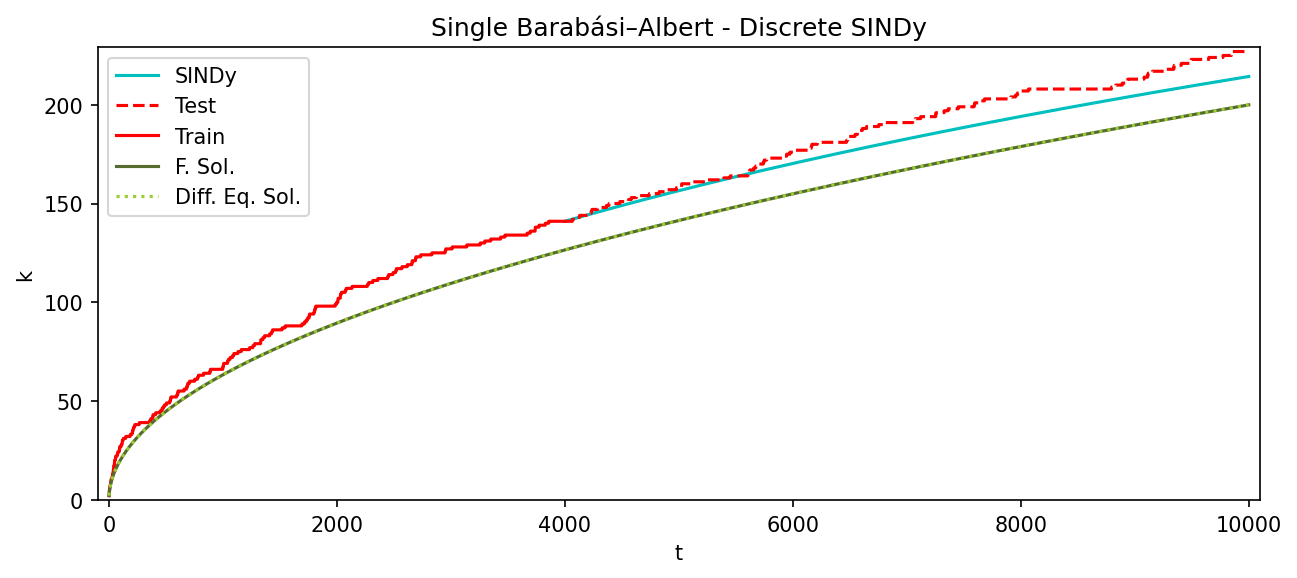

In [19]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('Single Barabási–Albert - Discrete SINDy')
plt.plot(t_test, sindy_sim, "c", label="SINDy")
plt.plot(t_test, k_test, "r--", label="Test")
plt.plot(t_train, k_train, "r", label="Train")
plt.plot(t, k_ant, color='darkolivegreen', label="F. Sol.")
plt.plot(t, k_dif, color='yellowgreen', linestyle='dotted', label="Diff. Eq. Sol.")
plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.ylabel("k")
plt.legend()
print(end='')

In [20]:
# Metrics DataFrame
get_metrics_df(k_test, sol_terms, sindy_model, narmax_model, sindy_sim, narmax_sim, sindy_time, narmax_time)

,CII,COI,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,Time
SINDy,[True],True,[2],[1],2,7.050066,67.501417,116.219979,0.006685
NARMAX,[True],True,[2],[1],2,7.050066,67.501417,116.219979,0.029781
